In [1]:
import sys
sys.path.append("../../src/other_methods")
sys.path.append("../..")

import yaml
import os
import numpy as np
import matplotlib.pyplot as plt

from PMMR.data_class import PVTrainDataSet, PVTestDataSet

from PMMR.kpv import KernelPVModelV2, KernelPVModel
from src.dsprite_ver2 import *
from src.utils.ml_utils import data_transform

In [2]:
seed = np.random.randint(1000000)
np.random.seed(seed)
train_dataset = generate_train_dsprite_ver2(n_sample = 2000, rand_seed = seed)
test_dataset = generate_test_dsprite_ver2()
transform_data = True

In [3]:
if transform_data:
    A = train_dataset.treatment
    Y = train_dataset.outcome
    Z = train_dataset.treatment_proxy
    W = train_dataset.outcome_proxy

    A_transformed, A_transformer = data_transform(A)
    Z_transformed, Z_transformer = data_transform(Z)
    W_transformed, W_transformer = data_transform(W)
    Y_transformed, Y_transformer = data_transform(Y)
    
    data_size = A_transformed.shape[0]
    A_transformed = np.array(A_transformed).reshape(data_size, -1)
    Z_transformed = np.array(Z_transformed).reshape(data_size, -1)
    W_transformed = np.array(W_transformed).reshape(data_size, -1)
    Y_transformed = np.array(Y_transformed).reshape(data_size, -1)

    train_dataset = PVTrainDataSet( treatment = A_transformed,
                                    treatment_proxy = Z_transformed,
                                    outcome_proxy = W_transformed,
                                    outcome = Y_transformed,
                                    backdoor = None)

In [4]:
kpv_params = {
                "lam1_max": 10.0,
                "lam1_min": 1e-4,
                "n_lam1_search": 100,
                "lam2_max": 10.0, 
                "lam2_min": 1e-4,
                "n_lam2_search": 100,
                # "lam1": 0.001,
                # "lam2": 0.001,
                "split_ratio": 0.5,
                "scale": 0.5,
            }


model = KernelPVModelV2(**kpv_params)
do_A = test_dataset.treatment
EY_do_A = test_dataset.structural

model.fit(train_dataset, "dsprite")

if transform_data:
    do_A_size = do_A.shape[0]
    do_A_transformed = (A_transformer.transform(do_A))
    f_struct_pred_transformed = model.predict(do_A_transformed)
    f_struct_pred = Y_transformer.inverse_transform(f_struct_pred_transformed.reshape(do_A_size, -1)).reshape(do_A_size, -1)
else:
    f_struct_pred = model.predict(do_A)
    
structured_pred_mse = (np.mean((f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1)) ** 2))
structured_pred_mae = (np.mean(np.abs(f_struct_pred.reshape(-1, 1) - EY_do_A.reshape(-1, 1))))

print("Structured function test set MSE: {}".format(structured_pred_mse))
print("Structured function test set MAE: {}".format(structured_pred_mae))

Structured function test set MSE: 23.79883410334579
Structured function test set MAE: 2.8500431633737744


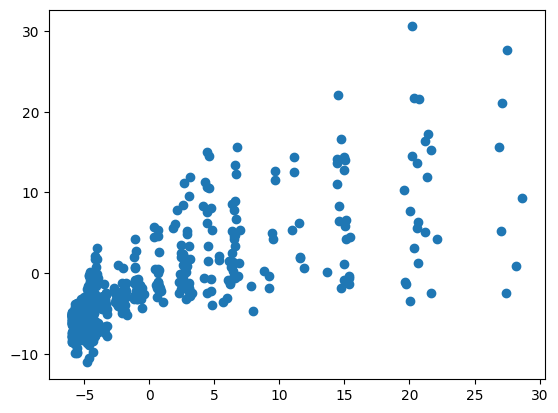

In [5]:
plt.scatter(EY_do_A, f_struct_pred)

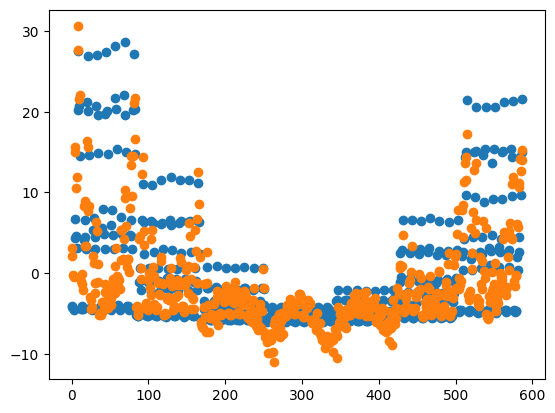

In [6]:
x = np.arange(EY_do_A.shape[0])
plt.scatter(x, EY_do_A)
plt.scatter(x, f_struct_pred)

In [7]:
model.lam1, model.lam2

(0.0009111627561154887, 0.21544346900318845)